In [45]:
import io
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

df_train = pd.read_parquet('mnist_dataset/train-00000-of-00001.parquet')
df_test = pd.read_parquet('mnist_dataset/test-00000-of-00001.parquet')

print(f"Training dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")
print(f"Column names: {df_train.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_train.head())

Training dataset shape: (60000, 2)
Test dataset shape: (10000, 2)
Column names: ['image', 'label']

First few rows:
                                               image  label
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      5
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      4
3  {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      1
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      9


Label: 5


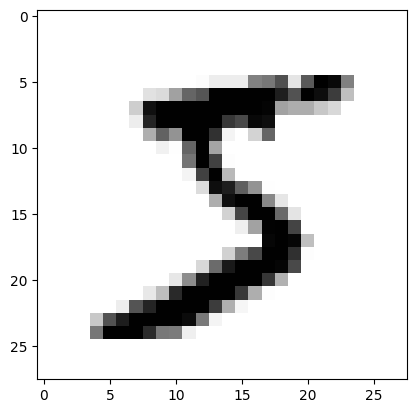

In [46]:
image_data = df_train['image'].iloc[0]['bytes']
image = Image.open(io.BytesIO(image_data))

print(f"Label: {df_train['label'].iloc[0]}")
plt.imshow(image, cmap=plt.cm.binary)
plt.show()

## Data Preprocessing for CNN

The preprocessing function below converts the raw MNIST image data into a format suitable for training a Convolutional Neural Network:

1. **Image Extraction**: Extracts binary PNG data from the dataset's image column
2. **Format Conversion**: Converts bytes to PIL Image, then to NumPy array
3. **Normalization**: Scales pixel values from 0-255 to 0-1 for better training performance
4. **Reshape**: Adds a channel dimension (28, 28, 1) required for CNN input
5. **Label Collection**: Extracts corresponding labels for supervised learning

This preprocessing ensures the data is in the correct format and range for optimal neural network training.

In [47]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

def preprocess_mnist_data(df):
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        # Extract image bytes and convert to PIL Image
        image_bytes = row['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes))
        
        # Convert to numpy array and normalize
        image_array = np.array(image).astype('float32') / 255.0
        image_array = image_array.reshape(28, 28, 1)  # Add channel dimension
        
        images.append(image_array)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

## CNN Model Architecture

Creates a sequential CNN with three convolutional blocks followed by dense layers for digit classification.

### Layer Structure
- **Conv2D + MaxPooling**: 32 filters → 64 filters → 64 filters
- **Feature Extraction**: 3x3 kernels with ReLU activation
- **Dimension Reduction**: 2x2 max pooling after first two blocks
- **Classification**: Dense layer (64 units) + Dropout (0.5) + Output (10 classes)

### Key Features
- **Input Shape**: (28, 28, 1) for grayscale MNIST images
- **Activation**: ReLU for hidden layers, softmax for output
- **Regularization**: Dropout prevents overfitting
- **Output**: 10 neurons for digits 0-9

In [48]:
def create_cnn_model():
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
    ])
    
    return model

## CNN Model Training

Train CNN model on MNIST data.

### Process Steps
1. **Data Preprocessing**: Convert raw images to normalized arrays
2. **Train/Validation Split**: 80/20 split with stratification to maintain class balance
3. **Model Setup**: Create CNN and compile with Adam optimizer
4. **Training**: Fit model with validation monitoring

In [49]:
def train_mnist_cnn(df_train, epochs, batch_size):
    X_train_full, y_train_full = preprocess_mnist_data(df_train)
    
    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train_full
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    
    model = create_cnn_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    print("\nTraining model...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1
    )

    return model, history

## Model Evaluation & Visualization
Evaluates trained CNN on test dataset and plots training/validation accuracy and loss curves for performance analysis.

In [53]:
def evaluate_model(model, history, df_test):
    X_test, y_test = preprocess_mnist_data(df_test)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    plt.figure(figsize=(12, 4))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Train CNN Model
Executes the training process with 10 epochs and batch size of 32.

In [51]:
model, history = train_mnist_cnn(df_train, epochs=10, batch_size=32)

Training set shape: (48000, 28, 28, 1)
Validation set shape: (12000, 28, 28, 1)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8189 - loss: 0.5725 - val_accuracy: 0.9804 - val_loss: 0.0652
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9703 - loss: 0.1015 - val_accuracy: 0.9864 - val_loss: 0.0470
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9811 - loss: 0.0666 - val_accuracy: 0.9888 - val_loss: 0.0420
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9853 - loss: 0.0527 - val_accuracy: 0.9890 - val_loss: 0.0426
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9870 - loss: 0.0477 - val_accuracy: 0.9877 - val_loss: 0.0454
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9906 - loss: 0.0335 - val_accuracy: 0.9882 - val_loss: 0.0416
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9914 - loss: 0.0300 - val_accuracy: 0.9894 - val_loss: 0.0433
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accurac

## CNN Model Evaluation
Test model accuracy and plot training history.

Test accuracy: 0.9929


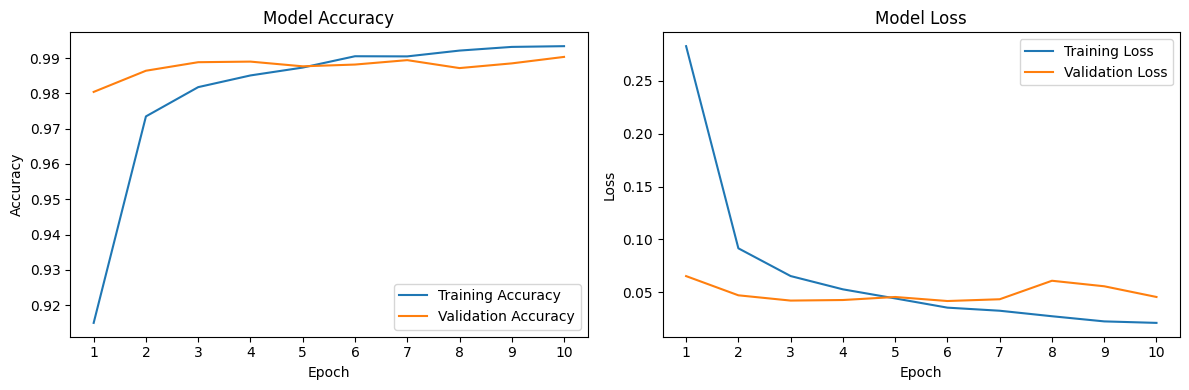

In [54]:
evaluate_model(model, history, df_test)

## Convolutional Neural Networks

<img src="../images/cnn.png" alt="Convolutional Neural Networks" width="640"/>

## CNN Intuition

<img src="../images/cnn_intuition.png" alt="CNN Intuition" width="640"/>